In [1]:
# Load libraries
from skimage.graph import route_through_array
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
# Get array index to the value that is closest to a given value
def get_closest(array, value):
    return np.abs(array - value).argmin()

## Load CMEMS wave analysis/forecast data

In [3]:

# Set file path
path = '/home/bpondi/optimized-ship-routing/data/CMEMS/GLOBAL_ANALYSIS_FORECAST_WAV_001_027'
file_waves = os.path.join(path,'mfwamglocep_2021051900_R20210510.nc')

In [4]:
print(file_waves)

/home/bpondi/optimized-ship-routing/data/CMEMS/GLOBAL_ANALYSIS_FORECAST_WAV_001_027/mfwamglocep_2021051900_R20210510.nc


In [5]:
# Load netCDF file into xarray
dataset_waves = xr.open_dataset(file_waves)
dataset_waves

<xarray.Dataset>
Dimensions:    (latitude: 2041, longitude: 4320, time: 8)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * latitude   (latitude) float64 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * time       (time) datetime64[ns] 2021-05-19T03:00:00 ... 2021-05-20
Data variables: (12/17)
    VHM0       (time, latitude, longitude) float32 ...
    VMDR_WW    (time, latitude, longitude) float32 ...
    VHM0_WW    (time, latitude, longitude) float32 ...
    VMDR_SW1   (time, latitude, longitude) float32 ...
    VTM01_SW1  (time, latitude, longitude) float32 ...
    VMDR_SW2   (time, latitude, longitude) float32 ...
    ...         ...
    VTPK       (time, latitude, longitude) float32 ...
    VSDX       (time, latitude, longitude) float32 ...
    VSDY       (time, latitude, longitude) float32 ...
    VPED       (time, latitude, longitude) float32 ...
    VTM02      (time, latitude, longitude) float32 ...
    VTM01_WW   (time, latitude, longitude) float32 ...
Attributes: (12/27)
    Conventions:                   CF-1.6
    time_coverage_start:           20210519-03:00:00
    time_coverage_end:             20210520-00:00:00
    date_created:                  20210510-07:34:00
    product_type:                  forecast
    product:                       GLOBAL_ANALYSIS_FORECAST_WAV_001_027
    ...                            ...
    geospatial_lon_step:           0.08332825
    geospatial_lon_units:          degree
    geospatial_lat_min:            -80.0
    geospatial_lat_max:            90.0
    geospatial_lat_step:           0.08333588
    geospatial_lat_units:          degree

## Load CMEMS physics analysis/forecast data

In [6]:
# Pending ....


## Define routing problem
Calculate the optimal shipping route between New York and Lisbon avoiding high waves.

New York: 40.7128° N, 74.0060° W
Lisbon: 38.7223° N, 9.1393° W


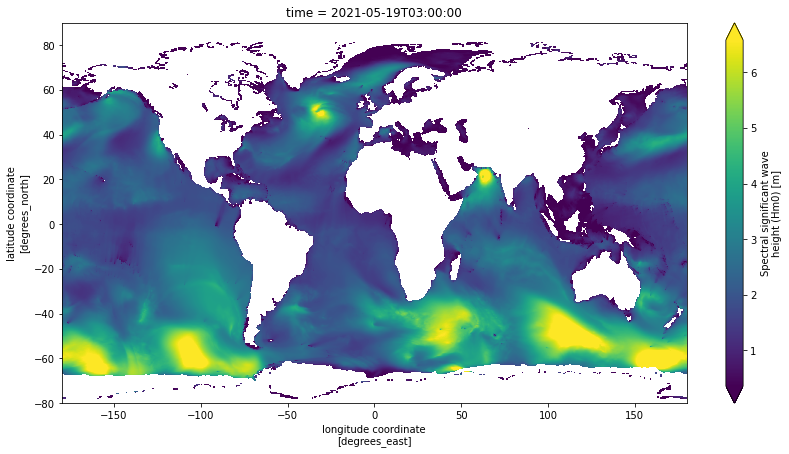

In [7]:
# Plot Wave Height variable in the dataset for a specific time slice
dataset_waves.VHM0.isel(time=0).plot(robust=True, aspect=2, size=7);

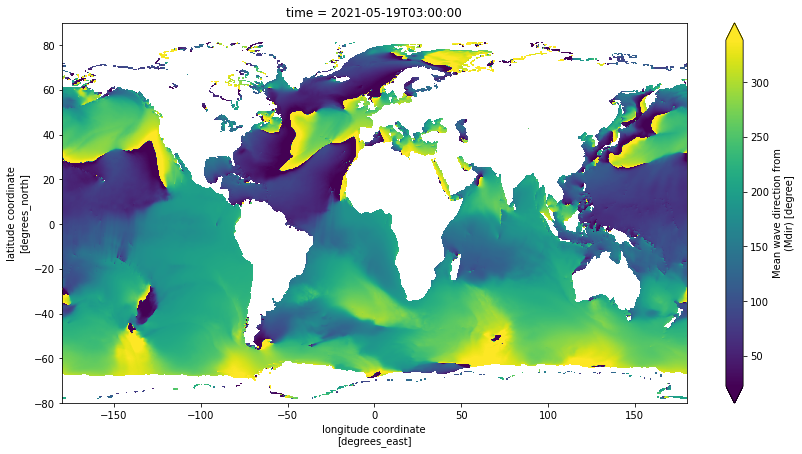

In [8]:
# Plot Mean Wave Direction variable in the dataset for a specific time slice
dataset_waves.VMDR.isel(time=0).plot(robust=True, aspect=2, size=7);

## Define area of interest

In [9]:
# Set bounding box for the allowed routing corridor
bbox = ((-80, 32),(-5, 47))
# Select time
time_slice = 0

In [10]:
# Get indices of the bbox
lon_min = get_closest(dataset_waves.longitude.data, bbox[0][0])
lat_min = get_closest(dataset_waves.latitude.data, bbox[0][1])
lon_max = get_closest(dataset_waves.longitude.data, bbox[1][0])
lat_max = get_closest(dataset_waves.latitude.data, bbox[1][1])

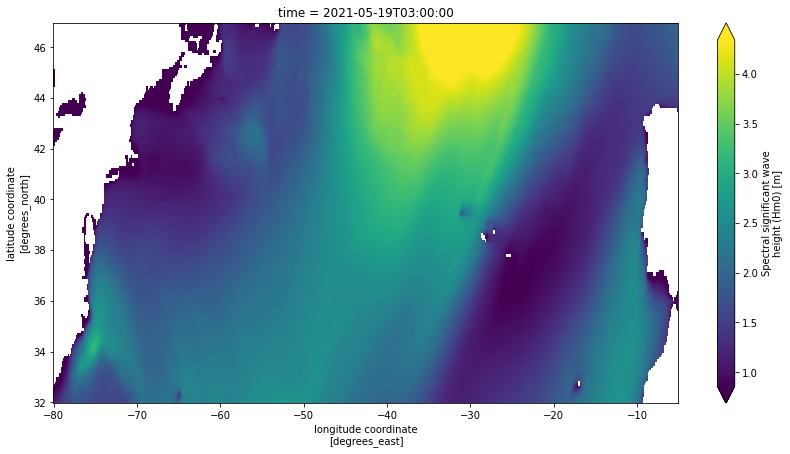

In [11]:
# Extract array  of wave height from dataset_waves to define the cost in the routing algorithm 
# -> subset space, time and variable
wave_height = dataset_waves.VHM0.isel(time=time_slice, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))
wave_height.plot(robust=True, aspect=2, size=7);

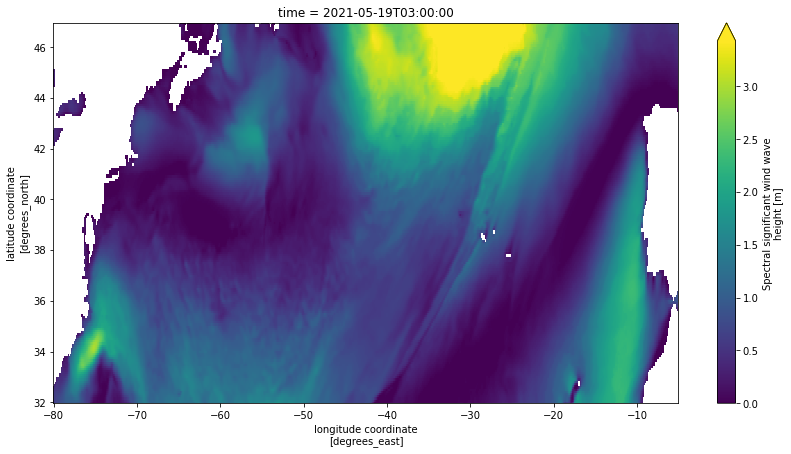

In [12]:
# Extract array of wind wave height from dataset_waves to define the cost in the routing algorithm 
# -> subset space, time and variable
wind_wave_height = dataset_waves.VHM0_WW.isel(time=time_slice, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))
wind_wave_height.plot(robust=True, aspect=2, size=7);

In [13]:
costs = wave_height.data + wind_wave_height.data
# Set NaN values to large costs as the algorithm cannot handle NaNs
costs[np.isnan(costs)] = 2 * np.nanmax(costs) 
np.shape(costs)

(180, 900)


## Define start/end point of route

In [14]:
lat_NY = 40.7128
lon_NY = -74.0060
lat_LS = 38.7223
lon_LS = -9.1393

In [15]:
start_lon = get_closest(wave_height.longitude.data, lon_NY)
start_lat = get_closest(wave_height.latitude.data, lat_NY)
end_lon = get_closest(wave_height.longitude.data,lon_LS)
end_lat = get_closest(wave_height.latitude.data,lat_LS)

In [16]:
start = (start_lat, start_lon)
end = (end_lat, end_lon)

## Calculate optimal route (minimum cost path)
Calculate optimal route based on the minimum cost path


In [17]:
# Optional parameters:
# - fully_connected 
#     - False -> only axial moves are allowed
#     - True  -> diagonal moves are allowed
# - geometric 
#     - False -> minimum cost path
#     - True  -> distance-weighted minimum cost path

indices, weight = route_through_array(costs, start, end, fully_connected=False, geometric=True)
indices = np.stack(indices, axis=-1)
indices

array([[105, 104, 104, ...,  80,  80,  81],
       [ 72,  72,  73, ..., 849, 850, 850]])

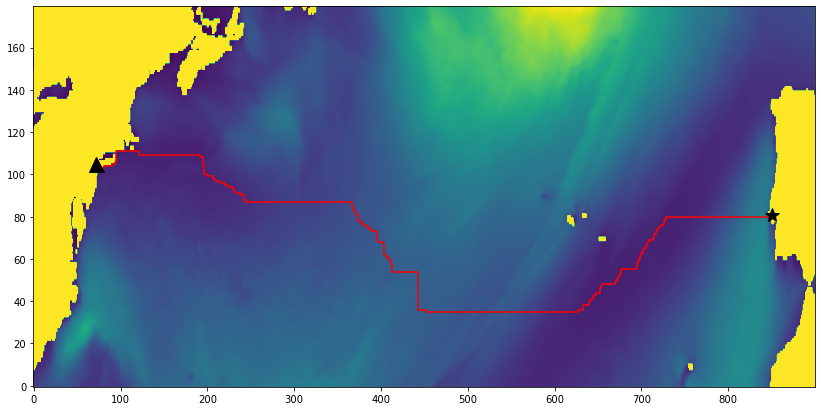

In [18]:
# Plot optimal route

plt.figure(figsize=(14,7))
# Costs
plt.imshow(costs, aspect='auto', vmin=np.min(costs), vmax=0.5*np.max(costs));
# Route
plt.plot(indices[1],indices[0], 'r')
# Start/end points
plt.plot(start_lon, start_lat, 'k^', markersize=15)
plt.plot(end_lon, end_lat, 'k*', markersize=15)
plt.gca().invert_yaxis();